In [134]:
using Revise
using Pkg; Pkg.activate(".")
using HypergraphModularity
using DataFrames
using SparseArrays
using RCall
using Random

Random.seed!(7777);

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


In [135]:
function projectedGraph(H)
    
    n = length(H.D)
    A = CliqueExpansion(H, false, false)
    ix, jx, w = findnz(A)
    E = Dict(sort([ix[k], jx[k]]) => w[k] for k in 1:length(ix))

    H̄ = hypergraph(collect(1:n), Dict(1 => Dict(), 2 => E), [0])
    HypergraphModularity.computeDegrees!(H̄);
    return H̄
end

projectedGraph (generic function with 1 method)

In [136]:
function experiment(H, Z, method, data_label)
    
    n = length(H.D)
    
    Z_ = collect(1:n)
    γ = 10.0
    H̄ = projectedGraph(H)
    
    # for warmstarts
    Z̄ = CliqueExpansionModularity(H, γ, false, true)
    Ω̄ = estimateΩEmpirically(H̄, Z̄; aggregator = p -> [length(p) == 1, sum(p)])
    Ω = estimateΩEmpirically(H, Z̄; aggregator = p -> [length(p) == 1, sum(p)])
    
    DF = DataFrame()
    
    for i in 1:10
        if method     == "dyadic_modularity"
            Z_ = CliqueExpansionModularity(H, γ, false, true)
            γ  = computeDyadicResolutionParameter(H, Z_)
        elseif method == "dyadic_likelihood"
            Z_ = SuperNode_PPLouvain(H̄, Ω̄;α = 0, verbose = false)
            Ω̄  = estimateΩEmpirically(H̄, Z_; aggregator = p -> [length(p) == 1, sum(p)])
        elseif method == "polyadic_likelihood"
            Z_ = SuperNode_PPLouvain(H, Ω; α = 0, verbose = false)
            Ω  = estimateΩEmpirically(H, Z_; aggregator = p -> [length(p) == 1, sum(p)])
        end
        
        γ = computeDyadicResolutionParameter(H, Z_)
        ωᵢ, ωₒ = computeDyadicResolutionParameter(H, Z_; mode="ω", weighted=false) 
        Q_D = dyadicModularity(H̄, Z_, γ; weighted=false)

        Ω̄  = estimateΩEmpirically(H̄, Z_; aggregator = p -> [length(p) == 1, sum(p)])
        L_D = modularity(H̄, Z_, Ω̄; α = 0)

        Ω  = estimateΩEmpirically(H, Z_; aggregator = p -> [length(p) == 1, sum(p)])
        Q_H = modularity(H, Z_, Ω; α = 0)
        
        df = DataFrame(
            Z      = Z, 
            Z_     = Z_, 
            method = method,
            dyadic_modularity    = round(convert(Float64, Q_D), digits = 2), 
            dyadic_likelihood    = round(convert(Float64, L_D), digits = 2),
            polyadic_likelihood    = round(convert(Float64, Q_H), digits = 2),
            round  = i,
            data   = data_label
        )
        
        DF = vcat(DF, df)
    end
    return DF
end

experiment (generic function with 1 method)

In [137]:
DF = DataFrame()

for method ∈ ["dyadic_modularity", "dyadic_likelihood", "polyadic_likelihood"]
    for data ∈ ["contact-high-school-classes", "contact-primary-school-classes"]
        kmax_ = 6
        H, Z = read_hypergraph_data(data,kmax_, 2, true)
        n = length(H.D)
        
        df = experiment(H, Z, method, data)
        DF = vcat(DF, df)
    end
end

In [138]:
R"""
library(tidyverse)
"""

RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


In [139]:
R"""
df <- tibble($DF)

df <- df %>% 
    pivot_longer(cols = c(dyadic_modularity, dyadic_likelihood, polyadic_likelihood), names_to = "metric", values_to = "value" ) %>% 
    filter(method == metric) %>% 
    group_by(method, data, metric) %>% 
    filter(value == max(value)) %>% 
    filter(round == min(round)) 

primary_labels <- read_csv("data/contact-primary-school-classes/label-names-contact-primary-school-classes.txt",
                    col_names = FALSE) %>% 
          mutate(num = row_number(),
                 data = "contact-primary-school-classes") %>% 
          rename(class = X1)

high_labels <- read_csv("data/contact-high-school-classes/label-names-contact-high-school-classes.txt",
                    col_names = FALSE) %>% 
          mutate(num = row_number(),
                 data = "contact-high-school-classes") %>% 
          rename(class = X1) 
        
labels <- rbind(primary_labels, high_labels)

df <- df %>% 
    left_join(labels, by = c("Z" = "num", "data" = "data"))
"""

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   X1 = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   X1 = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{VecSxp}
# A tibble: 1,707 x 8
# Groups:   method, data, metric [6]
       Z    Z_ method        round data                metric        value class
   <int> <int> <chr>         <int> <chr>               <chr>         <dbl> <chr>
 1     9     3 dyadic_modul…     4 contact-high-schoo… dyadic_modul…   0.6 MP   
 2     9     3 dyadic_modul…     4 contact-high-schoo… dyadic_modul…   0.6 MP   
 3     3     1 dyadic_modul…     4 contact-high-schoo… dyadic_modul…   0.6 2BIO3
 4     3     1 dyadic_modul…     4 contact-high-schoo… dyadic_modul…   0.6 2BIO3
 5     8     4 dyadic_modul…     4 contact-high-schoo… dyadic_modul…   0.6 PC*  
 6     8     4 dyadic_modul…     4 contact-high-schoo… dyadic_modul…   0.6 PC*  
 7     3     1 dyadic_modul…     4 contact-high-schoo… dyadic_modul…   0.6 2BIO3
 8     3     1 dyadic_modul…     4 contact-high-schoo… dyadic_modul…   0.6 2BIO3
 9     7     5 dyadic_modul…     4 contact-high-schoo… dyadic_modul…   0.6 PC   
10     7     5 dyadic_modul…     4

In [140]:
R"""

reorder_df <- df %>% 
    group_by(data, method, class, Z_) %>% 
    summarise(n = n()) %>% 
    ungroup() %>% 
    group_by(data, method, Z_) %>% 
    filter(n == max(n)) %>% 
    ungroup() %>% 
    group_by(data, method) %>% 
    mutate(Z__ = row_number()) %>% 
    select(-class, -n)

df <- df %>% 
   left_join(reorder_df)
"""

┌ Warning: RCall.jl: `summarise()` regrouping output by 'data', 'method', 'class' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Joining, by = c("Z_", "method", "data")
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{VecSxp}
# A tibble: 1,707 x 9
# Groups:   method, data, metric [6]
       Z    Z_ method       round data             metric      value class   Z__
   <int> <int> <chr>        <int> <chr>            <chr>       <dbl> <chr> <int>
 1     9     3 dyadic_modu…     4 contact-high-sc… dyadic_mod…   0.6 MP        3
 2     9     3 dyadic_modu…     4 contact-high-sc… dyadic_mod…   0.6 MP        3
 3     3     1 dyadic_modu…     4 contact-high-sc… dyadic_mod…   0.6 2BIO3     2
 4     3     1 dyadic_modu…     4 contact-high-sc… dyadic_mod…   0.6 2BIO3     2
 5     8     4 dyadic_modu…     4 contact-high-sc… dyadic_mod…   0.6 PC*       5
 6     8     4 dyadic_modu…     4 contact-high-sc… dyadic_mod…   0.6 PC*       5
 7     3     1 dyadic_modu…     4 contact-high-sc… dyadic_mod…   0.6 2BIO3     2
 8     3     1 dyadic_modu…     4 contact-high-sc… dyadic_mod…   0.6 2BIO3     2
 9     7     5 dyadic_modu…     4 contact-high-sc… dyadic_mod…   0.6 PC        4
10     7     5 dyadic_modu…     4 

┌ Warning: RCall.jl: `summarise()` regrouping output by 'class', 'Z__', 'method' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


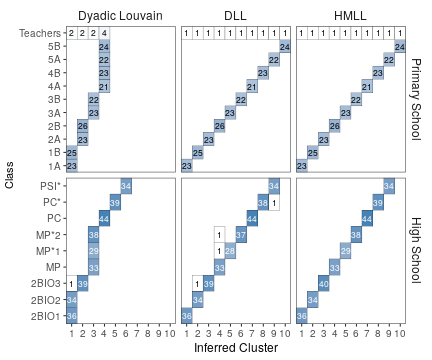

RObject{VecSxp}


In [141]:
R"""


df %>% 
    group_by(class, Z__, method, data) %>% 
    summarise(n = n()) %>% 
    mutate(method = case_when(
               method == "dyadic_likelihood" ~ "DLL",
               method == "dyadic_modularity" ~ "Dyadic Louvain",
               method == "polyadic_likelihood" ~ "HMLL"),
           data = case_when(
                data == "contact-high-school-classes" ~ "High School",
                data == "contact-primary-school-classes" ~ "Primary School"),
           method = factor(method, levels = c("Dyadic Louvain", "DLL", "HMLL")),
           data   = factor(data, levels = c("Primary School", "High School"))) %>% 
    ggplot() + 
    aes(x = Z__, y = class) + 
    facet_grid(data~method, scales = "free_y") + 
    geom_tile(aes(fill = n), color = "black") + 
    theme_bw() + 
    geom_text(aes(label = n, color = n < 27), size = 3) + 
    scale_color_manual(values = c("white", "black")) + 
    theme(panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(), 
          strip.background = element_blank(),
          strip.text = element_text(size = 12),
          axis.title.x = element_text(size = 12),
#          axis.title.y = element_blank(),
          axis.text.x = element_text(size = 10),
          axis.text.y = element_text(size = 10)) + 
    guides(color = FALSE, fill = FALSE) + 
    scale_x_continuous(expand = c(0,0), breaks = 1:10, labels = 1:10) + 
    scale_y_discrete(expand = c(0,0)) + 
    xlab("Inferred Cluster") + 
    ylab("Class") + 
    scale_fill_gradient(low = "white", high = "steelblue") 
"""

In [143]:
R"""
ggsave("fig/contact-clustering.png", width = 6.5, height = 4)
"""

RObject{NilSxp}
NULL


## Structure of $\Omega$

In [326]:
df = DataFrame()

plot()

for data ∈ ["contact-high-school-classes", "contact-primary-school-classes"]

    kmax = 5
    H, Z = read_hypergraph_data(data,kmax, 2, true)
    n = length(H.D)

    Ω  = estimateΩEmpirically(H, Z; aggregator = p -> [length(p) == 1, sum(p)]);
    
    β = [log(Ω.ω([1, i], 0)) - log(Ω.ω([0, i], 0)) for i in 2:kmax]
    γ = [(Ω.ω([1, i], 0) - Ω.ω([0, i], 0)) for i in 2:kmax]
    γ = γ ./ β
    
    m = [length(H.E[k]) for k in 2:kmax]
    
    df_ = DataFrame(γ = γ, β = β, m = m, D = sum(H.D), data = data, k = 2:kmax)
    
    
    df = vcat(df_, df)
    
    
    
#     plot!(2:kmax, (2:kmax).*m, label = data)
#     plot!(2:kmax, β.*m/(sum(m.*β)), seriestype = :scatter, label = data)
    
    plot!(2:kmax,  γ.*(big(sum(H.D)).^(2:kmax)) ./ m, seriestype = :scatter, label = data, yaxis = :log)
end

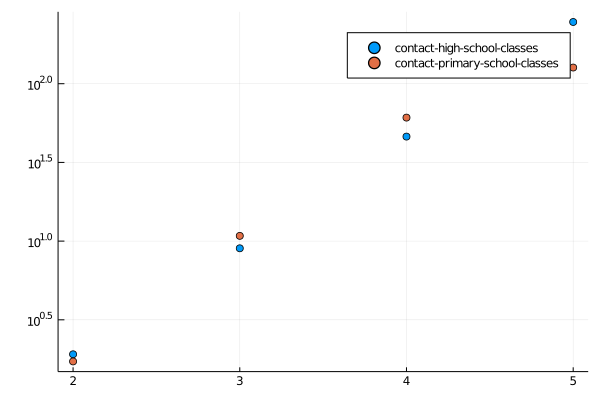

In [327]:
plot!()

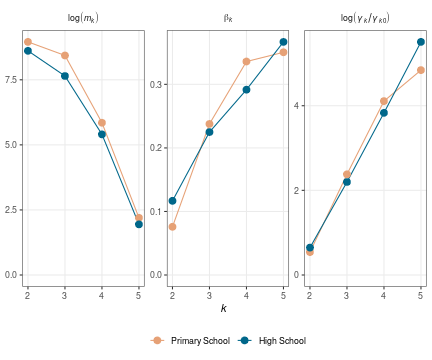

RObject{VecSxp}


In [388]:
R"""
tibble($df) %>% 
    group_by(data) %>% 
    mutate(γ = log(γ*(D^k)/m),
           β = β/sum(β),
           m = log(m),
           data = ifelse(data == "contact-primary-school-classes", "Primary School", "High School"),
           data = factor(data, levels = c("Primary School", "High School"))) %>% 
    pivot_longer(cols = c(γ, β, m), names_to = "type", values_to = "value") %>% 
    mutate(type = ifelse(type == "γ", "log(italic(γ[k]/γ[k][0]))", type),
           type = ifelse(type == "β", "italic(beta[k])", type),
           type = ifelse(type == "m", "log(italic(m[k]))", type),
           type = factor(type, levels = c("log(italic(m[k]))", "italic(beta[k])", "log(italic(γ[k]/γ[k][0]))"))) %>% 
    ggplot() + 
    aes(x = k, y = value, color = data) + 
    facet_wrap(~type, scales = "free_y", labeller = label_parsed) + 
    geom_line() + 
    geom_point(size = 3) + 
    theme_bw() + 
    theme(legend.position = "bottom",
          strip.background = element_blank(), 
          axis.title.y = element_blank(),
          legend.title = element_blank(),
          panel.grid.minor = element_blank()) +
    xlab(expression(italic(k))) + 
    scale_color_manual(values = c("#e6a176","#00678a" )) + 
    ylim(c(0, NA))
"""

In [390]:
R"""
ggsave("fig/contact-resolution.png", width = 7.5, height = 3.5)
"""

RObject{NilSxp}
NULL


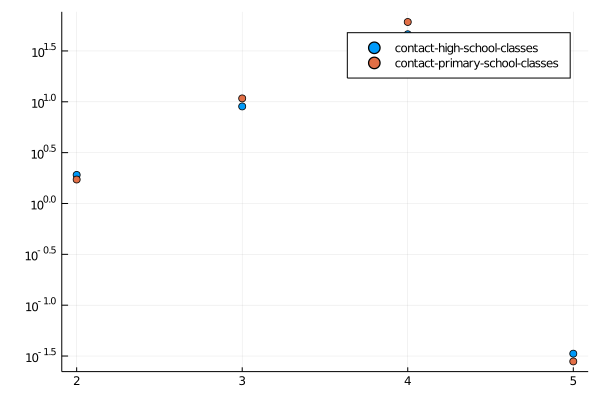

In [289]:
plot!()

# Inspect Partition

In [202]:
R"""
df <- tibble($DF)

df %>% 
    filter(method == "dyadic_likelihood") %>% 
    filter(dyadic_likelihood == max(dyadic_likelihood)) %>% 
    mutate(i = row_number()) %>% 
    group_by(Z, Z_) %>% 
    summarise(n = n(), i = max(i)) 
"""

┌ Warning: RCall.jl: `summarise()` regrouping output by 'Z' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{VecSxp}
# A tibble: 13 x 4
# Groups:   Z [9]
       Z    Z_     n     i
   <int> <int> <int> <int>
 1     1     3    36   325
 2     2     8    34   324
 3     3     5    39   130
 4     3     8     1   127
 5     4     2     1   169
 6     4     4    28   327
 7     5     2     1    72
 8     5     7    37   320
 9     6     6    34   326
10     7     9    44   322
11     8     1    38   306
12     8     6     1   251
13     9     2    33   323


In [204]:
data = "contact-high-school-classes"
kmax = 5
H, Z = read_hypergraph_data(data,kmax, 2, true)

(hypergraph
  N: Array{Int64}((327,)) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  318, 319, 320, 321, 322, 323, 324, 325, 326, 327]
  E: Dict{Int64,Dict}
  D: Array{Int64}((327,)) [36, 44, 33, 72, 74, 66, 53, 63, 117, 35  …  45, 8, 38, 44, 12, 55, 16, 2, 64, 10]
, [9, 9, 3, 3, 8, 8, 3, 3, 7, 7  …  9, 4, 5, 9, 7, 9, 2, 1, 6, 4])

In [213]:
problem_nodes = [127, 169, 72, 251]

4-element Array{Int64,1}:
 127
 169
  72
 251

In [241]:
k = 4

h = 0

for i in problem_nodes
    print(i)
    print("  ")
    for k in 2:kmax
        h = 0
        for e in keys(H.E[k])
            if i ∈ e h += H.E[k][e] end
        end
        print(h) 
        print(" ")
    end
    println("")
end

127  54 44 13 2 
169  47 13 1 0 
72  70 47 5 0 
251  34 12 1 0 


In [240]:
H.D[problem_nodes]

4-element Array{Int64,1}:
 113
  61
 122
  47

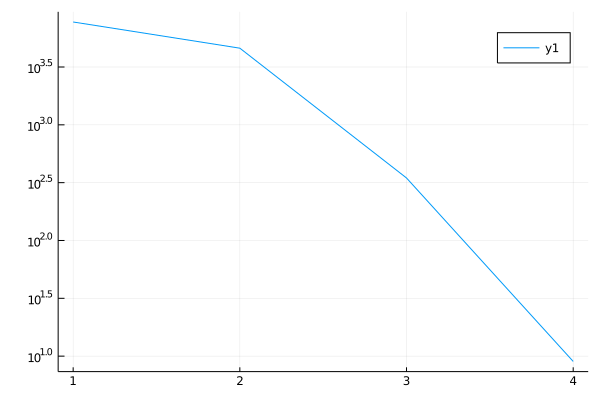

In [381]:
plot([length(H.E[k]) for k in 2:kmax], yaxis = :log)